In [1]:
# !pip install pandas statsmodels

In [2]:
from typing import List, Dict
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning

warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=ValueWarning)

# SVAR fitting

The following is code that reads CSV data corresponding to shift, Tm, and group from datasets/preprocessed and estimates SVAR. For lags, it uses the pre-estimated values recorded in var_estimation_result.csv.

In [3]:
from statsmodels.tsa.vector_ar.svar_model import SVAR
import pandas as pd
import numpy as np

shift = "original"
Tm = "T1"
group_with_sep = "1_0"

var_result = pd.read_csv("./var_estimation_result.csv")
X = pd.read_csv(f"./datasets/preprocessed/{shift}/{Tm}/{group_with_sep}.csv", index_col=0)

# A matrix that represent recursive constraint. E will be estimated. 
A = np.array([
    [1, 0, 0],
    ["E", 1, 0],
    ["E", "E", 1]
])

lag = var_result[(var_result["group"] == group_with_sep) & (var_result["Tm"] == Tm) & (var_result["period_shift"] == shift)].iloc[0].lag 

model = SVAR(X, svar_type="A", A=A)
results = model.fit(maxlags=lag)

# IRF Calculation

The impulse response can be calculated using `irf = results.irf(period)`, and in the case of SVAR, the calculation results are stored in `irf.svar_irfs`. When the `irf.plot` function is called, an n✕n figure is displayed. The shape of svar_irfs is a third-order tensor of dimensions (period, n, n).

In [4]:
# In our paper, period=200.
period = 20
irf = results.irf(period)

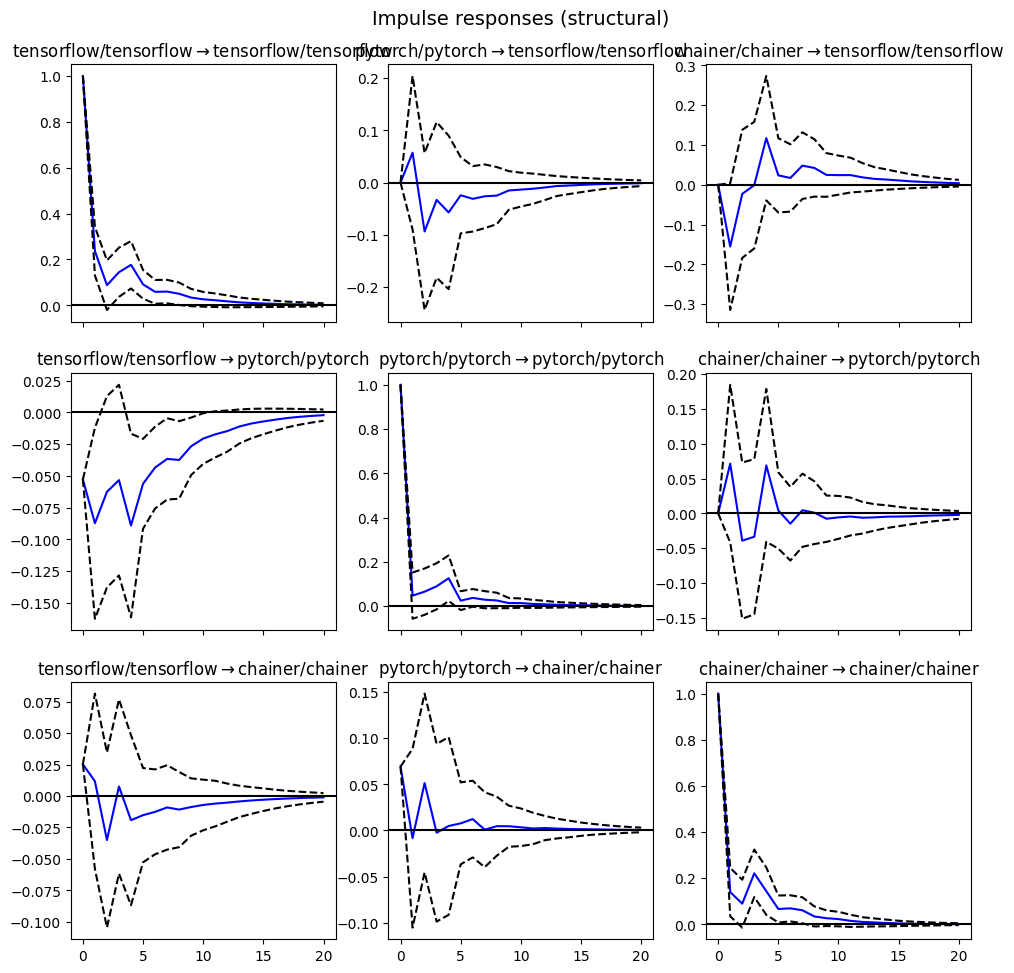

In [5]:
irf.plot();

## IRF Cum Effects

The cumulative impulse response can be obtained from `irf.svar_cum_effects`. The shape of it is same as svar_irfs. 

In [6]:
irf.svar_cum_effects.shape

(21, 3, 3)

In [7]:
# svar_cum_effects of tensorflow -> tensorflow
irf.svar_cum_effects[:, 0, 0]

array([1.        , 1.23628194, 1.3241545 , 1.46838325, 1.64501697,
       1.7363857 , 1.79522934, 1.85515227, 1.90543833, 1.93922122,
       1.96551654, 1.98766538, 2.0050593 , 2.01803683, 2.0282963 ,
       2.0364709 , 2.04283419, 2.04773272, 2.05157155, 2.05457866,
       2.05691406])

In [8]:
# svar_cum_effects of pytorch -> chainer
irf.svar_cum_effects[:, 2, 1]

array([0.06921286, 0.06077537, 0.11215823, 0.10964349, 0.11443707,
       0.12209011, 0.13438356, 0.13512219, 0.13971457, 0.14424278,
       0.14763872, 0.14972951, 0.15228383, 0.15428155, 0.15584442,
       0.15715892, 0.15832854, 0.15924695, 0.16000393, 0.16063349,
       0.16115074])

The last index of irf.svar_cum_effects corresponds to the SCE (Shock Cumulative Effect) between each pair of OSS.

In [9]:
irf.svar_cum_effects[-1]

array([[ 2.05691406, -0.31257996,  0.22904872],
       [-0.64402635,  1.51820073,  0.00813646],
       [-0.10294346,  0.16115074,  1.92371124]])

# MIAO Score Calculation

MIAO Score definition. 

$$
\mathrm{MS}_{ij} = (-1) \cdot \sum_{k=1}^m \mathrm{SCE}_{ij}^k
$$

In [10]:
shifts = ["original", "1_month_shifted", "2_month_shifted", "3_month_shifted"]
Tms = ["T1", "T2", "T3", "T4"]
group_with_sep = "1_0"

def miao_score(sces: List[float]) -> float:
    """
    Calculate MS_{ij} from list of SCE
    """
    return (-1)*np.sum(sces)

def easy_miao_phase1_with_period_shifts(A_mat: np.ndarray, shifts: List[str] , \
                                        Tms: List[str], group_with_sep: str) -> List[Dict[str, List[float]]]:
    """
    This function performs a simplified version of MIAO Phase 1 and outputs the SCE (Shock Cumulative Effect) for $A_i -> A_j$. 
    In addition to the standard algorithm, period shifts are taken into consideration.
    
    The reason it is simplified is that it uses time series data after the following preprocessing steps have already been completed:
    
    * Extraction of subsequences corresponding to Tm
    * Time series stationarization through ADF testing and fractional differencing
    * Seasonal adjustment
    * Optimal lag order estimation
    """

    def generate_irf_pair(labels: List[str]) -> Dict[str, List[str]]:
        result = {}
    
        for i in range(len(labels)):
            for j in range(len(labels)):
                key = "{}x{}".format(i, j)
                value = [labels[j], labels[i]]
                result[key] = value
                
        return result
    
    sces_with_shifts = []
    
    for shift in shifts:
        sces = {}
        for Tm in Tms:
            X = pd.read_csv(f"./datasets/preprocessed/{shift}/{Tm}/{group_with_sep}.csv", index_col=0)
            pair = generate_irf_pair(X.columns)

            cond = (var_result["group"] == group_with_sep) & (var_result["Tm"] == Tm) & (var_result["period_shift"] == shift)
            lag = var_result[cond].iloc[0].lag
            
            model = SVAR(X, svar_type="A", A=A_mat)
            results = model.fit(maxlags=lag)
    
            irf = results.irf(200)
    
            n = len(X.columns)
    
            for from_ in range(n):
                for to_ in range(n):
                    if from_ == to_:
                        continue
                    
                    left, right = pair[f"{from_}x{to_}"]                
                    label = f"{left} -> {right}"
                    if label not in sces:
                        sces[label] = []
                    
                    sce = irf.svar_cum_effects[-1, from_, to_]
                    sces[label].append(sce)
    
        sces_with_shifts.append(sces)

    return sces_with_shifts

def calculate_ams_table(sces_with_shifts: Dict[str, List[float]]) -> pd.DataFrame:    
    """
    Calculate AMS_{ij} and construct the MIAO score table. 
    """
    
    ams = {}

    for sces in sces_with_shifts:
        for key in sces:
            if key not in ams:
                ams[key] = 0
    
            ms = miao_score(sces[key])
            ams[key] += np.sum(ms)
    
    table = pd.DataFrame({
        "AMS_ij": [v/len(shifts) for v in ams.values()]
    }, index=ams.keys())

    return table

In [11]:
sces_with_shifts = easy_miao_phase1_with_period_shifts(A, shifts, Tms, group_with_sep)
ams_table = calculate_ams_table(sces_with_shifts)

display(ams_table)

,AMS_ij
pytorch/pytorch -> tensorflow/tensorflow,-2.950758
chainer/chainer -> tensorflow/tensorflow,-4.014750
tensorflow/tensorflow -> pytorch/pytorch,0.025875
chainer/chainer -> pytorch/pytorch,-0.950557
tensorflow/tensorflow -> chainer/chainer,-0.852760
pytorch/pytorch -> chainer/chainer,2.375542
